In [12]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# MovieLens RecSys Kaggle competition

Flàvia Ferrús, Jordi Segura, Pol Riba

Upload and prepare the needed packages:

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pathlib import Path
from zipfile import ZipFile
import re
from sklearn.model_selection import train_test_split

!mkdir models

mkdir: cannot create directory ‘models’: File exists


In order to prepare an optimal Recommender System to recommend the top 25 movies for each user we may consider a combination of Factorization Machines for the users we have a lot of data from, this is, usual users that have relativelly a lot of ratings, and a top ranked recommender for the new users, i.e. the users we have less information from. This way, we can focus on recommending popular or top movies to the users from whom we do not have enough information to create a fair user profile. 

Meanwhile, we may implement a Factorization Machine to take advantage of the information we have from usual users with several modifications according to our intuition and the observations and conclusions we obtain from each implementation. 

# Experiment setting


On the following notebook different experiments are conducted. A brief introduction is presented in order to get a general view on the structure of the implementations:
- EXPERIMENT 0: 
    - MODEL: 
        - Factorization Machines with interactions until 2nd order, 
        - RMSE
    - FEATURE ENGINEERING:
        1. user ID, user age, user sex, user occupation frequency, movie ID and movie genre:
            - We have considered an additional feature encoding, by computing the ocuppation frequency for each category of occupations in order to create an encoding with a more intuitive distance between the different types 
- EXPERIMENT 1: 
    - MODEL: 
        - Factorization Machines with interactions until 2nd order working as a Classifier: we consider the targe feature to be a binary feature: `loved`, defined as `0` if it is rated under `THRESH = 3.8` and `1` otherwise. 
        - Binary Cross Entropy
    - FEATURE ENGINEERING:
        1. user ID, user age, user sex, movie ID and movie genre 
        2. user ID, user age, user sex, user occupation frequency, movie ID and movie genre 
        3. user ID, user age, user sex, user occupation frequency, last N movies seen, movie ID, movie genre 
            - We are considering the additional feature `last N movies seen` by the user at the specific time `timestamp` at which the user is require to rate a determined movie. Thus, we take into account the tendency that the specific user follows at that time, and we are also giving an additional importance to the most popular movies. 
- EXPERIMENT 2: 
    - MODEL: 
        - Factorization Machines  / Deep Factorization Machines 
        - NDCGL
    - FEATURE ENGINEERING: 
        1. Normalized ratings by users and by gender: 
            - Classifier: personalized TRHES 
            - Regression: use the normalized ratings
        2. Normalized ratings by users:
            - Classifier: personalized TRHES 
            - Regression: use the normalized ratings
            
            
User grouping for all the experiment in order to identify the new users and the users that have a lot of ratings, and therefore a lo of information gathered. We have considered the mean over the frequency of ratings for all the users, and the ones above. 

# Loading data and defining functions

In [14]:
## FACTORIZATION MODELS

# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-1m.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-1m"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")


def load_ratings(movielens_dir):
    """
    Loads the ratings data from the Movielens dataset.

    Parameters:
    movielens_dir (str): The directory where the Movielens dataset is stored.

    Returns:
    pandas.DataFrame: A DataFrame containing the ratings data.
    """
    COL_NAME = ['uid','mid','rating','timestamp']
    df = pd.read_csv(movielens_dir / 'ratings.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df


def load_movies(movielens_dir):
    """
    Loads the movies data from the Movielens dataset.

    Parameters:
    movielens_dir (str): The directory where the Movielens dataset is stored.

    Returns:
    pandas.DataFrame: A DataFrame containing the movies data.
    """
    COL_NAME = ['mid','movie_name','movie_genre']
    df = pd.read_csv(movielens_dir / 'movies.dat',sep='::', header=None, engine='python', names=COL_NAME, encoding='latin-1')
    return df


def load_users(movielens_dir):
    """
    Loads the users data from the Movielens dataset.

    Parameters:
    movielens_dir (str): The directory where the Movielens dataset is stored.

    Returns:
    pandas.DataFrame: A DataFrame containing the users data.
    """
    # fea1 => Sex
    # fea2 => Age
    # fea3 => Occupation
    # fea4 => Zip-Code
    COL_NAME = ['uid','user_sex','user_age','user_occup','user_zip']
    df = pd.read_csv(movielens_dir / 'users.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df


def text2seq(text, n_genre):
    """
    Encodes a multi-level categorical feature using tokenizer.

    Parameters:
    text (str): The text to be encoded.
    n_genre (int): The number of genres to use for encoding.

    Returns:
    numpy.ndarray: The encoded sequence.
    """
    tokenizer = Tokenizer(lower=True, split='|',filters='', num_words=n_genre)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=3,padding='post')
    return seq


def last_n(df_ratings, n=3, column_name1 = "movie_name", column_name2 = "mid", column_name3 = "movie_year"):
    """
    Generates a new dataframe with columns that contain the last n ratings for each user.

    Parameters:
    df_ratings (pandas.DataFrame): The original ratings dataframe.
    n (int, optional): The number of last ratings to retrieve. Defaults to 3.
    column_name1 (str, optional): The name of the column for movie names. Defaults to "movie_name".
    column_name2 (str, optional): The name of the column for movie IDs. Defaults to "mid".
    column_name3 (str, optional): The name of the column for movie release years. Defaults to "movie_year".

    Returns:
    pandas.DataFrame: The new dataframe with columns containing the last n ratings for each user.
    """

    temp_list = [f'temp1_{i}' for i in range(n)]
    temp_list2 = [f'temp2_{i}' for i in range(n)]
    temp_list3 = [f'temp3_{i}' for i in range(n)]
    
    list_cols1 = []
    list_cols2 = []
    list_cols3 = []
    
    for movie_lag in range(n):
        movie_lag_shift = (movie_lag+1)*-1
        
        df_ratings[temp_list[movie_lag]] = df_ratings.groupby('uid',as_index= False)[column_name1].transform(lambda x : x.shift(movie_lag_shift))
        df_ratings[temp_list2[movie_lag]] = df_ratings.groupby('uid',as_index= False)[column_name2].transform(lambda x : x.shift(movie_lag_shift))
        df_ratings[temp_list3[movie_lag]] = df_ratings.groupby('uid',as_index= False)[column_name3].transform(lambda x : x.shift(movie_lag_shift))
                          
        if pd.isna(df_ratings[temp_list[movie_lag]].iloc[1]):
            pass
       
        else:
            list_cols1.append(temp_list[movie_lag])
            list_cols2.append(temp_list2[movie_lag])
            list_cols3.append(temp_list3[movie_lag])
    
    output_col_name1 = "last_x_"+column_name1
    output_col_name2 = "last_x_"+column_name2
    output_col_name3 = "last_x_"+column_name3
    
    df_ratings[output_col_name1] = df_ratings[list_cols1].values.tolist()
    df_ratings[output_col_name2] = df_ratings[list_cols2].values.tolist()
    df_ratings[output_col_name3] = df_ratings[list_cols3].values.tolist()
    
    return df_ratings


# Define a function to remove 'nan' values from a list
def remove_nan(input_list):
    """
    Removes NaN values from a list.

    Parameters:
    input_list (list): The input list.

    Returns:
    list: The input list with NaN values removed.
    """
    return [x for x in input_list if not pd.isnull(x)]


def complete_list(x, n):
    """
    Completes a list with zeros until it reaches a given length.

    Parameters:
    x (list): The input list.
    n (int): The desired length of the output list.

    Returns:
    numpy.ndarray: The completed list with zeros.
    """

    try:
        if len(x) < n:
            return np.concatenate([x, [0 for _ in range(n-len(x))]], axis=0)
        else:
            return x
    except:
            return np.zeros(n)

n_genre = 15


ratings = load_ratings(movielens_dir)
movies = load_movies(movielens_dir)
users = load_users(movielens_dir)


print("====== rating.dat ======")
print(ratings.head())
print("===== movies.dat ======")
print(movies.head())
print("====== users.dat ======")
print(users.head())


====== rating.dat ======
   uid   mid  rating  timestamp
0    1  1193       5  978300760
1    1   661       3  978302109
2    1   914       3  978301968
3    1  3408       4  978300275
4    1  2355       5  978824291
===== movies.dat ======
   mid                          movie_name                   movie_genre
0    1                    Toy Story (1995)   Animation|Children's|Comedy
1    2                      Jumanji (1995)  Adventure|Children's|Fantasy
2    3             Grumpier Old Men (1995)                Comedy|Romance
3    4            Waiting to Exhale (1995)                  Comedy|Drama
4    5  Father of the Bride Part II (1995)                        Comedy
====== users.dat ======
   uid user_sex  user_age  user_occup user_zip
0    1        F         1          10    48067
1    2        M        56          16    70072
2    3        M        25          15    55117
3    4        M        45           7    02460
4    5        M        25          20    55455


# Preprocessing

## Feature Engineering:

### Remarkable considerations:

- movie year: it can give to the model properties or implicit information about the movie and maybe some patterns in users can be found.
- timestamp: we rebuild the timestamp feature. Conversion to days and centered at 0. Can give some useful temporal information. 
    - After some computations, we have seen that it makes more sense to use this feature in order to define a new variable: last N movies seen, at this given time, by the user, in order to get a more informative new feature. 
- user occupation: we recompute the user_occupation in order to avoid the numerical order that was implicit there, and used a frequency value which made more sense, although it still has this order.
- the last N movies, in our case 3, watched by a user at a specific time, given by the variable `timestamp`. So basically, we can use the implicit information this feature can give us as well as give an extra weight to the top popular movies, this is, the movies that are more frequently seen by the users, and therefore, may be more repeated on this new feature


Note additionally, that the ratings seem to follow a slitghly asymetrical normal distribution, with mean 3.6 and median 4. Note that taking out the low ranked outliers, which may represent the movies some users have hardly dislikes, it is intuitive to consider a 3.8 to be an acceptable threshold in order to distinguish the movies that have actually liked the users. Therefore, in order to define the feature target `loved` in the cases that binary targets are used we may consider this `THRES = 3.8` as a coherent threshold. 

In [15]:
# Definition of variables
LAST_N_MOVIES = 3
LIKE_THRESH = 3.8

### Preprocessing and feature engineering!

# Break movie_genre, convert it into numbers
movies['movie_genre'] = text2seq(movies.movie_genre.values, n_genre=n_genre).tolist()

# JOIN all dataframes in one
ratings = ratings.join(movies.set_index('mid'), on = 'mid', how = 'left')
ratings = ratings.join(users.set_index('uid'), on = 'uid', how = 'left')

# Break year of movies into a new column. Clean name of movies
ratings['movie_year'] = ratings.movie_name.apply(lambda x: re.compile(r"\((\d{4})\)").search(x).group(1)).astype(int) # Get the year inside brackets (1998) => 1998
ratings['movie_name'] = ratings.movie_name.apply(lambda x: re.split(re.compile(r"\((\d{4})\)"), x)[0]) # Get the name cleaned

# Map the frequency of user_ocuppation, breaking the order.
ratings['user_ocupp_freq'] = ratings.user_occup.map(ratings.user_occup.value_counts())/ratings.shape[0]

# Timestamp is in seconds, convert
ratings['ts_day'] = round((ratings.timestamp - ratings.timestamp.min())/60/60/24)

# Sex binary encoded 
ratings['user_sex_encoded'] = ratings.user_sex.replace({'F': 0, 'M': 1})

# Create last_n_movies.
ratings = ratings.sort_values(by=['uid', 'timestamp'], ascending=False)
ratings = last_n(ratings, LAST_N_MOVIES, "movie_name", "mid", "movie_year")
ratings = ratings.drop([f'temp{i}_{j}' for i in range(1,LAST_N_MOVIES+1) for j in range(LAST_N_MOVIES)], axis=1)
# Apply the function to each row of the 'Values' column
ratings['last_x_movie_name'] = ratings['last_x_movie_name'].apply(remove_nan)
ratings['last_x_mid'] = ratings['last_x_mid'].apply(remove_nan)
ratings['last_x_movie_year'] = ratings['last_x_movie_year'].apply(remove_nan)
ratings['last_x_mid'] = ratings['last_x_mid'].apply(lambda x: complete_list(x,LAST_N_MOVIES)) # For users which do not have at least n movies.

# BINARY SCORE
ratings['loved'] = ratings.rating.apply(lambda x: 1 if x>LIKE_THRESH else 0)

print("====== PREPROCESSED DATA =======")
(ratings.head())

====== PREPROCESSED DATA =======


,uid,mid,rating,timestamp,movie_name,movie_genre,user_sex,user_age,user_occup,user_zip,movie_year,user_ocupp_freq,ts_day,user_sex_encoded,last_x_movie_name,last_x_mid,last_x_movie_year,loved
1000042,6040,1221,4,998315055,"Godfather: Part II, The","[3, 10, 1]",M,25,6,11106,1974,0.037197,482.0,1,"[Crimson Tide , Pi , As Good As It Gets ]","[161.0, 1921.0, 1784.0]","[1995.0, 1998.0, 1997.0]",1
1000167,6040,161,3,997454486,Crimson Tide,"[1, 4, 11]",M,25,6,11106,1995,0.037197,472.0,1,"[Pi , As Good As It Gets , Body Heat ]","[1921.0, 1784.0, 2917.0]","[1998.0, 1997.0, 1981.0]",0
999988,6040,1921,4,997454464,Pi,"[8, 4, 0]",M,25,6,11106,1998,0.037197,472.0,1,"[As Good As It Gets , Body Heat , Eat Drink Ma...","[1784.0, 2917.0, 232.0]","[1997.0, 1981.0, 1994.0]",1
1000172,6040,1784,3,997454464,As Good As It Gets,"[2, 1, 0]",M,25,6,11106,1997,0.037197,472.0,1,"[Body Heat , Eat Drink Man Woman , Blazing Sad...","[2917.0, 232.0, 3671.0]","[1981.0, 1994.0, 1974.0]",0
1000019,6040,2917,4,997454429,Body Heat,"[10, 4, 0]",M,25,6,11106,1981,0.037197,472.0,1,"[Eat Drink Man Woman , Blazing Saddles , Fugit...","[232.0, 3671.0, 457.0]","[1994.0, 1974.0, 1993.0]",1


# Users grouping

We may consider the different user groups, in terms of the rating frequency, so we can split the dataset between new users and usual users, in order to determine which kind of recommender system is more suitable to use in each case:

In order to implement our Recommender System, we may create a function that, for each given user from the test set, i.e. for each `uid` of the test set: it generates a subset from the initial dataset `ratings` with all the movies that the user has not seen matched with the specific user profile, and therefore it applies the FM recommender system to predict the ratings of the aforementioned movies for the given fixed user. Thus it sorts the dataset in terms of the predicted rating, to obtain the final ranking list of the top 25 movies to recommend to the given user. 

In [16]:
users = pd.unique(ratings['uid'])
users_freq = []
for user in users:
    users_freq.append(len(ratings[ratings['uid'] == user]))
mean_users_freq = np.sum(users_freq)/len(users_freq)
print('The mean frequency by user is: ', mean_users_freq)

df_freqs = pd.DataFrame({
    'user_id': users, 
    'users_freq': users_freq
})
df_freqs = df_freqs.sort_values(by = 'users_freq', ascending=False)
# df_freqs

df_popu = df_freqs[df_freqs['users_freq'] >= mean_users_freq]
df_new = df_freqs[df_freqs['users_freq'] < mean_users_freq]
print('The number of users identified as new users is: ', len(df_new))
print('The number of users identified as frequent users is: ', len(df_popu))

The mean frequency by user is:  165.5975165562914
The number of users identified as new users is:  4148
The number of users identified as frequent users is:  1892


0.6867549668874172


<AxesSubplot:>

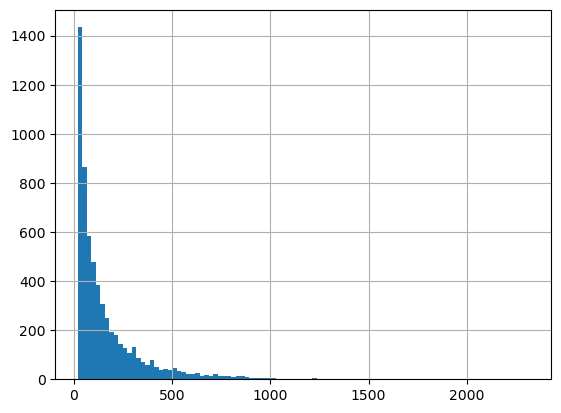

In [17]:
print(len(df_new)/(len(df_popu) + len(df_new)))
df_freqs.users_freq.hist(bins = 100)

Since we have a dataset with more than two thirds of users rating less than the mean frequency, we are considering this mean as the threshold for identifying a new and a frequent user on the experiments. 

Now, we may start by preprocessing the data and study all the explicit and implicit information we are given. 


3.581564453029317
4.0


<AxesSubplot:>

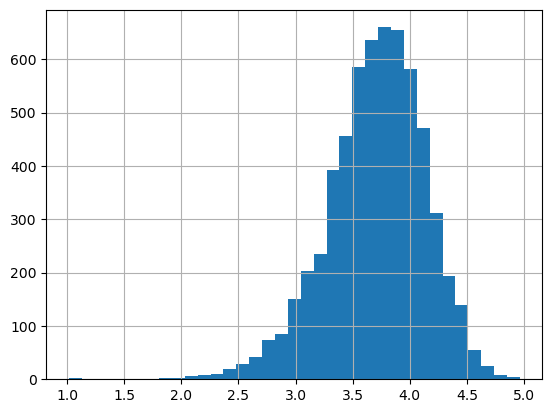

In [18]:
print(ratings.rating.mean())
print(ratings.rating.median())
ratings.groupby('uid').rating.mean().hist(bins = 35)

## Advanced engineering

On the latest experiments, we have included a new study in order to create a normalize target of ratings. Here we are considering the normalization of the ratings by user (so we can reduce or neglict the bias given by the way each user rates, we can hate users that tend to rate high by 

In [21]:
# Normalize rating
def normalize(uid, genre, rating):
    try:
        return (rating - ratings_min[(uid, genre)])/(ratings_max[(uid, genre)]-ratings_min[(uid, genre)])*5
    except:
        return 0
# Assign norm
def assign_norm(uid, mid):
    return renorm_rating[(uid, mid)]
# Assign user thresh
def norm_thresh(uid, mid):
    return ratings_mean[(uid, mid)]
# Assign personalized loved thresh
def assign_loved_thresh(rating, uid_thresh):
    return int(rating > uid_thresh)

# Copy of the DF
ratings__ = ratings
# Explode the movie_genre list into N new rows.
ratings__ = ratings__.explode('movie_genre').reset_index()
# Get the necessary data into dicts to faster lookup
ratings_mean = ratings__.groupby(by=['uid', 'movie_genre']).rating.mean().to_dict()
ratings_min = ratings__.groupby(by=['uid', 'movie_genre']).rating.min().to_dict()
ratings_max = ratings__.groupby(by=['uid', 'movie_genre']).rating.max().to_dict()
# Assign a normalized rating for each user and genre
ratings['norm_rating'] = ratings__[['uid', 'movie_genre', 'rating']].apply(lambda x: normalize(*x), axis=1)
# Get the mean rating for that user.
renorm_rating = ratings.groupby(by=['uid', 'mid']).norm_rating.mean().to_dict()
# Assign the threshold for each user and genre
ratings__['norm_thresh'] = ratings__[['uid', 'movie_genre']].apply(lambda x: norm_thresh(*x), axis=1)
# Put the user personalized threshold
ratings['uid_thresh'] = ratings.uid.map(ratings__.groupby('uid').norm_thresh.mean().to_dict())
# Put the user personalized loved feature
ratings['loved_thresh'] = ratings[['rating', 'uid_thresh']].apply(lambda x: assign_loved_thresh(*x), axis=1)

In [22]:
ratings.head()

,uid,mid,rating,timestamp,movie_name,movie_genre,user_sex,user_age,user_occup,user_zip,...,user_ocupp_freq,ts_day,user_sex_encoded,last_x_movie_name,last_x_mid,last_x_movie_year,loved,norm_rating,uid_thresh,loved_thresh
1000042,6040,1221,4,998315055,"Godfather: Part II, The","[3, 10, 1]",M,25,6,11106,...,0.037197,482.0,1,"[Crimson Tide , Pi , As Good As It Gets ]","[161.0, 1921.0, 1784.0]","[1995.0, 1998.0, 1997.0]",1,3.75,3.577713,1
1000167,6040,161,3,997454486,Crimson Tide,"[1, 4, 11]",M,25,6,11106,...,0.037197,472.0,1,"[Pi , As Good As It Gets , Body Heat ]","[1921.0, 1784.0, 2917.0]","[1998.0, 1997.0, 1981.0]",0,5.00,3.577713,0
999988,6040,1921,4,997454464,Pi,"[8, 4, 0]",M,25,6,11106,...,0.037197,472.0,1,"[As Good As It Gets , Body Heat , Eat Drink Ma...","[1784.0, 2917.0, 232.0]","[1997.0, 1981.0, 1994.0]",1,3.75,3.577713,1
1000172,6040,1784,3,997454464,As Good As It Gets,"[2, 1, 0]",M,25,6,11106,...,0.037197,472.0,1,"[Body Heat , Eat Drink Man Woman , Blazing Sad...","[2917.0, 232.0, 3671.0]","[1981.0, 1994.0, 1974.0]",0,2.50,3.577713,0
1000019,6040,2917,4,997454429,Body Heat,"[10, 4, 0]",M,25,6,11106,...,0.037197,472.0,1,"[Eat Drink Man Woman , Blazing Saddles , Fugit...","[232.0, 3671.0, 457.0]","[1994.0, 1974.0, 1993.0]",1,3.75,3.577713,1


# Factorization Machine Model definition

## Define input layers
The dataset contains a **numeric** and **categerical** features, they need to be treated differently.

* **numeric features** can be concatenated to inputs, with shape (None, num_of_numeric)
* **categorical features** can be encoded individually to inputs, with shape (None, 1) each.


In [24]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def define_input_layers():
    """
    Defines the input layers for a neural network model.

    Returns:
    list: A list of input layers for the model.
    """
    
    # numerical features
    user_ocupp_freq_input = Input((1,), name = 'user_ocupp_freq')
    user_age_input = Input((1,), name = 'user_age')
    
    ## num_inputs = [user_ocupp_freq_input, ts_day_input, movie_year_input, user_age_input]
    num_inputs = [user_ocupp_freq_input, user_age_input]
    
    # single level categorical features
    uid_input = Input((1,), name = 'input_uid') #user_id
    mid_input = Input((1,), name= 'input_mid')  #movie_id
    user_sex_input = Input((1,), name= 'user_sex')  #movie_id
    
    cat_sl_inputs = [uid_input, mid_input, user_sex_input]

    # multi level categorical features (with 3 genres at most)
    genre_input = Input((3,), name = 'input_genre')
    last_x_mid = Input((3,), name = 'last_x_mid')
    cat_ml_inputs = [genre_input, last_x_mid]

    inputs = num_inputs + cat_sl_inputs + cat_ml_inputs
    
    return inputs





## 1st order factorization machines
1st order will require features to map to a scalar. so for:

* numeric feature: a dense layer will convert tensor to shape (None,1)
* categorical feature: an embedding layer will convert tensor to shape (None,1,1) and then reshape layer to reshape to (None,1)

In [42]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    """
    Creates a mean pooling layer for a TensorFlow Keras model.

    Parameters:
    name (str): The name for the layer.
    keepdims (bool): Whether to keep the dimensions of the layer.

    Returns:
    tensorflow.keras.layers.Lambda: A mean pooling layer for the model.
    """
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

def fm_1d(inputs, n_uid, n_mid, n_sex, n_genre):
    """
    Creates a 1D factorization machine layer for a TensorFlow Keras model.

    Parameters:
    inputs (list): A list of input layers for the model.
    n_uid (int): The number of user IDs to use.
    n_mid (int): The number of movie IDs to use.
    n_sex (int): The number of sex categories to use.
    n_genre (int): The number of genres to use.

    Returns:
    tensorflow.keras.layers.Add: A 1D factorization machine layer for the model.
    """
    
    # user feat3 + user embedding + movie embedding + genre embedding
    #fea3_input, uid_input, mid_input, genre_input = inputs
    user_ocupp_freq_input, user_age_input, uid_input, mid_input, user_sex_input, genre_input, last_x_mid = inputs
    
    # all tensors are reshape to (None, 1)
    num_dense_1d = [Dense(1, name = 'num_dense_1d_user_ocupp_freq')(user_ocupp_freq_input),
                   Dense(1, name = 'num_dense_1d_user_age')(user_age_input)]
    cat_sl_embed_1d = [Embedding(n_uid + 1, 1, name = 'cat_embed_1d_uid')(uid_input),
                        Embedding(n_mid + 1, 1, name = 'cat_embed_1d_mid')(mid_input), 
                        Embedding(n_sex + 1, 1, name = 'cat_embed_1d_sex')(user_sex_input)]

    cat_ml_embed_1d = [Embedding(n_genre + 1, 1, mask_zero=True, name = 'cat_embed_1d_genre')(genre_input),
                      Embedding(n_genre + 1, 1, mask_zero=True, name = 'cat_embed_1d_last_x_mid')(last_x_mid)]

    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d]
    cat_ml_embed_1d = [Tensor_Mean_Pooling(name = f'embed_1d_mean_{idx}')(i) for idx,i in enumerate(cat_ml_embed_1d)]
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d + cat_ml_embed_1d)
    
    return y_fm_1d



## 2nd order factorization machines

In 2nd order FM, each feature is map to shape (None, 1, k) and then stack to concat_embed_2d layer with shape (None, p, k).
k - matrix factorization latent dimension, p is feature dimension.

the calculation of interaction terms can be simplified, using
\begin{equation*} 
\sum{x_ix_j} = \frac{1}{2} \left((\sum{x})^2 - \sum({x}^2)\right) 
\end{equation*}

Hence, the sum of 2nd order interactions = square of sum of concat_embed_2d - sum of squared concat_embed_2d in p dimension, the resulting tensor will have a shape (None, k)

> We are considering all the interactions between features here:

In [43]:

def fm_2d(inputs, n_uid, n_mid, n_sex, n_genre, k):
    """
    Creates a 2D factorization machine layer for a TensorFlow Keras model.

    Parameters:
    inputs (list): A list of input layers for the model.
    n_uid (int): The number of user IDs to use.
    n_mid (int): The number of movie IDs to use.
    n_sex (int): The number of sex categories to use.
    n_genre (int): The number of genres to use.
    k (int): The dimensionality of the embedding vectors.

    Returns:
    tuple: A tuple of two tensors, where the first tensor represents the second-order factorization machine interactions between the features, and the second tensor represents the embeddings of the features.
    """

    user_ocupp_freq_input, user_age_input, uid_input, mid_input, user_sex_input, genre_input, last_x_mid= inputs
    
    ### First we get all the representations: for each kind of variables
    
    num_dense_2d = [Dense(k, name = 'num_dense_2d_user_ocupp_freq')(user_ocupp_freq_input),
                   Dense(k, name = 'num_dense_2d_user_age')(user_age_input)]
    
    ## We need the numerical feature to also be a vector so it has shape k and it can interact with the rest of the matrices:
    
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d] # shape (None, 1, k)

    cat_sl_embed_2d = [Embedding(n_uid + 1, k, name = 'cat_embed_2d_uid')(uid_input), 
                       Embedding(n_mid + 1, k, name = 'cat_embed_2d_mid')(mid_input),
                       Embedding(n_sex + 1, k, name = 'cat_embed_2d_sex')(user_sex_input)] # shape (None, 1, k)
    
    cat_ml_embed_2d = [Embedding(n_genre + 1, k, name = 'cat_embed_2d_genre')(genre_input), 
                      Embedding(n_genre + 1, k, name = 'cat_embed_2d_last_x_mid')(last_x_mid)] # shape (None, 3, k)
    cat_ml_embed_2d = [Tensor_Mean_Pooling(name = f'cat_embed_2d_genre_mean_{idx}', keepdims=True)(i) for idx,i in enumerate(cat_ml_embed_2d)] # shape (None, 1, k)

    # concatenate all 2d embed layers => (None, ?, k)
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d + cat_ml_embed_2d)

    # calcuate the interactions by simplication
    # sum of (x1*x2) = sum of (0.5*[(xi)^2 - (xi^2)])
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')

    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)

    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)

    sub = Subtract()([square_of_sum, sum_of_square])
    sub = Lambda(lambda x: x*0.5)(sub)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d


In [44]:

def fm_model(n_uid, n_mid, n_sex, n_genre, k):
    """
    Creates a Factorization Machine model with 1D and 2D interaction terms for a TensorFlow Keras model.
    Parameters:
        n_uid (int): The number of user IDs to use.
        n_mid (int): The number of movie IDs to use.
        n_sex (int): The number of sex categories to use.
        n_genre (int): The number of genres to use.
        k (int): The dimensionality of the embedding vectors.

    Returns:
        tensorflow.keras.models.Model: A Factorization Machine model with 1D and 2D interaction terms for the model.
"""
    inputs = define_input_layers()
#     print(inputs)
    y_fm_1d = fm_1d(inputs, n_uid, n_mid, n_sex, n_genre)
    y_fm_2d, embed_2d = fm_2d(inputs, n_uid, n_mid, n_sex, n_genre, k)
#     print('model created')
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d])
    y = Dense(32, name='pre_out', activation='relu')(y)
    y = Dense(1, name = 'fm_output', activation='sigmoid')(y)
    
    fm_model = Model(inputs, y)
    return fm_model



In [45]:
def df2xy(ratings):
    """
    Converts a pandas dataframe of ratings into feature and target numpy arrays for training a machine learning model.

    Parameters:
    ratings (pandas.DataFrame): The dataframe of ratings with columns 'user_ocupp_freq', 'user_age', 'uid', 'mid', 'user_sex_encoded', and 'movie_genre'.

    Returns:
    tuple: A tuple of numpy arrays (x, y) where x contains the feature data and y contains the target data.
    """
    x = [ratings.user_ocupp_freq.values,
         ratings.user_age.values,
         ratings.uid.values, 
         ratings.mid.values, 
         ratings.user_sex_encoded.values,
         np.concatenate(ratings.movie_genre.values).reshape(-1,3),
        np.concatenate(ratings.last_x_mid.values).reshape(-1,3),
        ]
    y = ratings.loved_thresh.values
    return x,y



In [46]:
ratings.columns

Index(['uid', 'mid', 'rating', 'timestamp', 'movie_name', 'movie_genre',
       'user_sex', 'user_age', 'user_occup', 'user_zip', 'movie_year',
       'user_ocupp_freq', 'ts_day', 'user_sex_encoded', 'last_x_movie_name',
       'last_x_mid', 'last_x_movie_year', 'loved', 'norm_rating', 'uid_thresh',
       'loved_thresh'],
      dtype='object')

## Top recommender definition

In [47]:
class TopPopRecommender():
    """
    A Top-Popularity Recommender that recommends the most popular items in the training set.

    Attributes:
    train (pandas.DataFrame): The training dataset.
    popular_items (numpy.ndarray): The array of item IDs sorted by popularity.

    Methods:
    fit(train):
        Fits the model to the training dataset.

        Parameters:
        train (pandas.DataFrame): The training dataset.

    recommend(user_id, at=5, remove_seen=True):
        Recommends items to the user based on popularity.

        Parameters:
        user_id (int): The user ID.
        at (int): The number of items to recommend.
        remove_seen (bool): Whether to remove seen items from the recommended list.

        Returns:
        numpy.ndarray: An array of the recommended item IDs.
    """

    def fit(self, train):

        item_popularity = train[['mid','norm_rating']].groupby(by='mid').count()

        self.train = train
        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = item_popularity.sort_values(by='norm_rating',ascending=False).index
    
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            seen_items = self.train[self.train.uid==user_id].mid.values
            unseen_items_mask = np.in1d(self.popular_items, seen_items, assume_unique=True, invert = True)
            unseen_items = self.popular_items[unseen_items_mask]
            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]
    
        return recommended_items

In [48]:

def top_recomendations_v2(model_object, user_id, train, at = 5):
    """
    Recommends the top items for a user based on a trained model.
    
    Parameters:
        model_object (object): The trained machine learning model object.
        user_id (int): The user ID to generate recommendations for.
        train (pandas.DataFrame): The training dataset containing user and movie ratings.
        at (int): The number of top recommendations to generate.

    Returns:
        list: A list of recommended movie IDs for the specified user.
    """

    movies_watched_by_user = train[train.uid == user_id]
    movies_not_watched = train[~train["mid"].isin(movies_watched_by_user.mid.values)]
    
    movie_information = movies_not_watched
    movie_information.loc[:]['uid'] = random_user
    movie_information.loc[:]['user_sex_encoded'] = movies_watched_by_user.iloc[0]['user_sex_encoded']
    movie_information.loc[:]['user_age'] = movies_watched_by_user.iloc[0]['user_age']
    movie_information.loc[:]['user_ocupp_freq'] = movies_watched_by_user.iloc[0]['user_ocupp_freq']
    
    movie_information = movie_information.sort_values(by=['uid', 'timestamp'], ascending=False)
    movie_information = last_n(movie_information, n, "movie_name", "mid", "movie_year")
    movie_information = movie_information.drop([f'temp{i}_{j}' for i in range(1,LAST_N_MOVIES+1) for j in range(LAST_N_MOVIES)], axis=1)

    movie_information['last_x_movie_name'] = movie_information['last_x_movie_name'].apply(remove_nan)
    movie_information['last_x_mid'] = movie_information['last_x_mid'].apply(remove_nan)
    movie_information['last_x_movie_year'] = movie_information['last_x_movie_year'].apply(remove_nan)
    movie_information['last_x_mid'] = movie_information['last_x_mid'].apply(lambda x: complete_list(x,LAST_N_MOVIES)) # For users which do not have at least n movies.

    ## We drop duplicates from the generated dataset
    movie_information = movie_information.drop_duplicates(subset = 'mid')
    
    random_user_x, random_user_y = df2xy(movie_information)
    random_user_prediction = model_object.predict(random_user_x).flatten()
    
    ## This gets the indices of the top predicted ratings 
    top_ratings_indices = random_user_prediction.argsort()[-at:][::-1]
    
    ## We get the movie indices located on the corresponding indexs: 
    recommended_movie_ids = [movie_information.iloc[index]['mid'] for index in top_ratings_indices]
        
    return recommended_movie_ids

## Train/Test splitting

In [49]:
train, val = train_test_split(ratings, test_size=0.2, random_state=7)

train_x, train_y = df2xy(train)
valid_x, valid_y = df2xy(val)


## Model training

### Top popular recommender system:

In [50]:
topPopular = TopPopRecommender()
topPopular.fit(train)

### Factorization Machines Recommender system

On the first tries, the Factorization Machine RecSys has been trained as a Linear Regression estimator, optimizing a Mean Square error loss. Therefore, the results obtained were far from accurate, given the character of our dataset and the problem we seek to solve. 

---

In [51]:
params = {
    'n_uid': ratings.uid.max(),
    'n_mid': ratings.mid.max(),
    'n_sex': ratings.user_sex_encoded.max(),
    'n_genre': 14,
    'k':20
    #'dnn_dr': 0.5
}

fm_model = fm_model(**params)


In [52]:
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint
# train  model
fm_model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

early_stop = EarlyStopping(monitor='val_loss', patience=3)
model_ckp = ModelCheckpoint(filepath='./models/deepfm_weights.h5', 
                            monitor='val_loss',
                            save_weights_only=True, 
                            save_best_only=True)
callbacks = [model_ckp,early_stop]
train_history = fm_model.fit(train_x, train_y, 
                                  epochs=30, batch_size=2048, 
                                  validation_data=(valid_x, valid_y),
                                  callbacks = callbacks)

Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node 'model/cat_embed_2d_last_x_mid/embedding_lookup' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_597/4055212193.py", line 16, in <module>
      callbacks = callbacks)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/core/embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'model/cat_embed_2d_last_x_mid/embedding_lookup'
indices[1877,1] = 1461 is not in [0, 15)
	 [[{{node model/cat_embed_2d_last_x_mid/embedding_lookup}}]] [Op:__inference_train_function_4170]

## Predictions:

We predict the ratings obtained by used our FM model in order to validate the accuracy of our model.

In [ ]:
ratings_predictions = fm_model.predict(valid_x).flatten()

In [ ]:
val['ratings_prediction']= ratings_predictions
val

In [ ]:
print(min(ratings_predictions))
print(max(ratings_predictions))

## Submission

We load the corresponding dataset, and we create the `solutio` file. In order to do so:
- We get each `uid` from the test set and check whether they are a new or a usual user
    - If it is new: we recommend him the top popular movies using the *Top Popular RecSys*
    - If it is usual: we use the *FM RecSys* to recommend him a sorted list for this specific user, as specified before. 

In [ ]:
test = pd.read_csv('/kaggle/input/recsysmasterfds/kaggle_baseline.csv')

In [ ]:
import csv
from tqdm import tqdm 

# open the file in the write mode
with open('solution.csv', 'w',encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)
    # write a row to the csv file
    writer.writerow(['user_id', 'prediction'])
    for user_id in tqdm(test.user_id.unique()):
        if user_id in pd.unique(df_popu['user_id']):
            relevant_items = top_recomendations_v2(fm_model, user_id, ratings, 25)
        else: 
            relevant_items = topPopular.recommend(user_id, at=25)
        list_relevants = ' '.join([str(elem) for elem in relevant_items])
        writer.writerow([str(user_id),list_relevants])

# EXPERIMENT 2


In this 2nd experiment, we will basically use the TOP LAST N movies feature, which it should contain very rich information for the model. We will also try another approach in terms of the model, we will try to classify instead of doing regression on ratings. We will create a new feature called *loved* that is if a user liked that movie or not, with a THRESHOLD of 3.5, declared above. Therefore the task of the model will be to determine if the user liked an specific movie or not.

Doing it this way, we must change the loss for a Cross Entropy and we will use a SoftMax in order to get continuos values to better sort the movies.

In [ ]:
params = {
    'n_uid': ratings.uid.max(),
    'n_mid': ratings.mid.max(),
    'n_sex': ratings.user_sex_encoded.max(),
    'n_genre': 14,
    'k':20
    #'dnn_dr': 0.5
}

fm_model = fm_model(**params)

## Train/Test splitting

In [ ]:
train, val = train_test_split(ratings, test_size=0.2, random_state=7)
train_x, train_y = df2xy(train)
valid_x, valid_y = df2xy(val)

### User grouping - Two model approach


We may consider the different user groups, in terms of the rating frequency, so we can split the dataset between new users and usual users, in order to determine which kind of recommender system is more suitable to use in each case:

In [ ]:
users = pd.unique(ratings['uid'])
users_freq = []
for user in users:
    users_freq.append(len(ratings[ratings['uid'] == user]))
mean_users_freq = np.sum(users_freq)/len(users_freq)
print(mean_users_freq)

In [ ]:
df_freqs = pd.DataFrame({
    'user_id': users, 
    'users_freq': users_freq
})
df_freqs = df_freqs.sort_values(by = 'users_freq', ascending=False)
df_freqs

In [ ]:
df_popu = df_freqs[df_freqs['users_freq'] >= mean_users_freq]
df_new = df_freqs[df_freqs['users_freq'] < mean_users_freq]
print(len(df_new))
print(len(df_popu))

In [ ]:
ratings2 = pd.DataFrame(columns = ratings.columns)
for user in df_popu.user_id: 
    ratings2 = pd.concat([ratings2, ratings[ratings['uid'] == user]])
    
ratings2

## Model training

### Top popular recommender system:

In [ ]:
topPopular = TopPopRecommender()
topPopular.fit(train)

### Factorization Machines Recommender system

On the first tries, the Factorization Machine RecSys has been trained as a Linear Regression estimator, optimizing a Mean Square error loss. Therefore, the results obtained were far from accurate, given the character of our dataset and the problem we seek to solve. 

--- 

Therefore, on the subsequent steps, we have added an additional layer to the Factorization Machine model in order to create a Classifier, that can predict whether a movie is relevant for a specific user or not, insetead of using a Linear Regression. Thus, we may use a `sigmoid` activation function, and a `cross-entropy loss` in order to adjust the training of the Factorization Machine model to a more suitable model for our problem. 

Moreover, we could consider the actual rating as weight in the `fit` function, in order to ensure that the model actually considers the top rated movies for each user, since those are the ones we want to focus on in order to improve our model.

---

In [ ]:
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint
# train  model
fm_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_ckp = ModelCheckpoint(filepath='./models/deepfm_weights.h5', 
                            monitor='val_loss',
                            save_weights_only=True, 
                            save_best_only=True)
callbacks = [model_ckp,early_stop]
train_history = fm_model.fit(train_x, train_y, 
                                  epochs=100, batch_size=2048, 
                                  validation_data=(valid_x, valid_y),
                                  callbacks = callbacks)

## Predictions:

We predict the ratings obtained by used our FM model in order to validate the accuracy of our model.

In [ ]:
ratings_predictions = fm_model.predict(valid_x).flatten()

In [ ]:
val['ratings_prediction']= ratings_predictions
val

In [ ]:
print(min(ratings_predictions))
print(max(ratings_predictions))

## Submission

We load the corresponding dataset, and we create the `solutio` file. In order to do so:
- We get each `uid` from the test set and check whether they are a new or a usual user
    - If it is new: we recommend him the top popular movies using the *Top Popular RecSys*
    - If it is usual: we use the *FM RecSys* to recommend him a sorted list for this specific user, as specified before. 

In [ ]:
test = pd.read_csv('/kaggle/input/recsysmasterfds/kaggle_baseline.csv')

In [ ]:
import csv
from tqdm import tqdm 

# open the file in the write mode
with open('solution.csv', 'w',encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)
    # write a row to the csv file
    writer.writerow(['user_id', 'prediction'])
    for user_id in tqdm(test.user_id.unique()):
        if user_id in pd.unique(df_popu['user_id']):
            relevant_items = top_recomendations_v2(fm_model, user_id, ratings, 25)
        else: 
            relevant_items = topPopular.recommend(user_id, at=25)
        list_relevants = ' '.join([str(elem) for elem in relevant_items])
        writer.writerow([str(user_id),list_relevants])